# Preparing a GHZ state and running the circuit on simulators

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

This hello-world tutorial prepares a paradigmatic example for a multi-qubit entangled state, the so-called [GHZ state](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state) (named after the three physicists Greenberger, Horne and Zeilinger). The GHZ state is extremely non-classical, and therefore very sensitive to decoherence. Therefore, it is often used as a performance benchmark for today's hardware. Moreover, in many quantum information protocols it is used as a resource for quantum error correction, quantum communication and quantum metrology. 

Qrack and PyQrack offer several choices of "stackable layers" of classical simulation algorithms, all available as a local simulator and "bring-your-own-container" on AWS. You can seamlessly swap between different "layer stacks" without any modifications to the circuit definition, as shown below, by just passing PyQrack `args` and `kwargs` through the `run()` interface. For additional information about PyQrack, see the [PyQrack API Reference](https://pyqrack.readthedocs.io/en/latest/autoapi/pyqrack/qrack_simulator/index.html).

In [2]:
# general imports
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import numpy as np

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Observable
from braket.devices import Devices, LocalSimulator
from braket.aws import AwsDevice

### Problem: Prepare a GHZ State

Goal: Prepare an $N$-qubit GHZ state: 
$$\left|0,0, ...\right> \rightarrow \left|\mathrm{GHZ}\right> = \frac{1}{\sqrt{2}}\left(\left|0,0, ...\right> + \left|1,1, ...\right>\right).$$

The GHZ state is a quantum superposition of all subsystems being in state 0 with all of them being in state 1 (as often discussed in the famous Gedanken experiment of a cat being dead and alive at the same time). The GHZ state is a maximally entangled quantum state. 

To prepare this state, build and run the following circuit using a single-qubit Hadamard gate (denoted as H) acting on the first qubit followed by a series of two-qubit CNOT gates: 

<div align="center">
<img src="circuit.png" width="300"/>
</div>

### Setup Circuit

In [3]:
# function to build a GHZ state
def ghz_circuit(n_qubits):
    """
    function to return a GHZ circuit ansatz
    input: number of qubits
    """

    # instantiate circuit object
    circuit = Circuit()
    
    # add Hadamard gate on first qubit
    circuit.h(0)

    # apply series of CNOT gates
    for ii in range(0, n_qubits-1):
        circuit.cnot(control=ii, target=ii+1)

    return circuit

In [4]:
# define circuit
n_qubits = 10
ghz = ghz_circuit(n_qubits)

In [5]:
# print circuit
print(ghz)

T  : |0|1|2|3|4|5|6|7|8|9|
                          
q0 : -H-C-----------------
        |                 
q1 : ---X-C---------------
          |               
q2 : -----X-C-------------
            |             
q3 : -------X-C-----------
              |           
q4 : ---------X-C---------
                |         
q5 : -----------X-C-------
                  |       
q6 : -------------X-C-----
                    |     
q7 : ---------------X-C---
                      |   
q8 : -----------------X-C-
                        | 
q9 : -------------------X-

T  : |0|1|2|3|4|5|6|7|8|9|


### Default Optimal Simulator

First, the circuit is run locally using the default optimal simulator.

In [6]:
# set up device: Default Local Qrack Simulator
device = LocalSimulator(backend="qrack")

In [7]:
# run circuit
result = device.run(ghz, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
Counter({'0000000000': 508, '1111111111': 492})


Text(0, 0.5, 'counts')

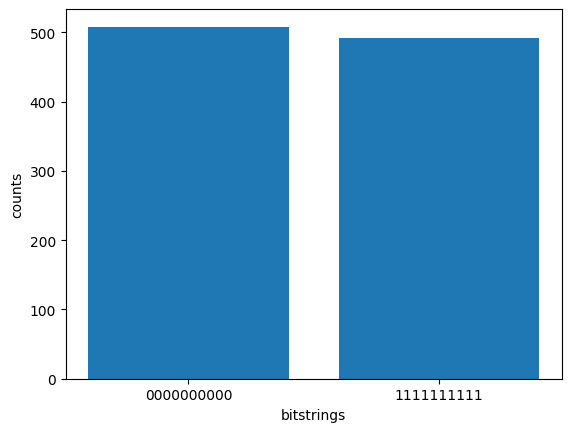

In [8]:
# plot using Counter
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')

As opposed to quantum hardware where only measurement shots can be obtained, with a classical simulator you can access the full state vector, amplitudes and expectation values of certain observables by assigning the corresponding result types. To do so, append the result types to the circuit before submitting it to run. This can be very useful for debugging. 

The example code below outputs the state vector. To reiterate, the following output is expected:
$$\left|\mathrm{GHZ}\right> = \frac{1}{\sqrt{2}}\left(\left|0,0,0\right> + \left|1,1,1\right>\right) = \left[\frac{1}{\sqrt{2}},0,0,0,0,0,0,\frac{1}{\sqrt{2}}\right].$$

In [9]:
# define circuit
n_qubits = 3
ghz = ghz_circuit(n_qubits)      

# add the state_vector ResultType
ghz.state_vector()
# print circuit including requested result types
print(ghz)

T  : |0|1|2|
            
q0 : -H-C---
        |   
q1 : ---X-C-
          | 
q2 : -----X-

T  : |0|1|2|

Additional result types: StateVector


In [10]:
# run the circuit and output the results
task = device.run(ghz, shots=0)
result = task.result()

# print results
print("Final EXACT state vector:\n", result.values[0])

Final EXACT state vector:
 [(0.70660400390625-0.0266603734344244j), 0j, 0j, 0j, 0j, 0j, 0j, (0.70660400390625-0.0266603734344244j)]


Clearly the expected results with perfect correlations between the three qubits making up the GHZ state are obtained.

Note that you can only request state vector and amplitude when shots = 0 for a classical simulator. When shots > 0, you cannot access the full state vector, but you can get approximate expectation values as taken from measurement samples. Note that Amazon Braket also supports probability, sample, expectation, and variance as result types for QPU devices.

### The "Special-Case" Simulators

Apart from the default optimal simulator, you can also run your circuit with optional "layers" designed for special cases.

See the [PyQrack API Reference](https://pyqrack.readthedocs.io/en/latest/autoapi/pyqrack/qrack_simulator/index.html) for the full set of algorithm "layer" options, but three are of particular note:
* Default optimal (no options)

    This configuration includes all optimizations besides "hybrid stabilizer" and quantum binary decision diagrams simulation.
* isStabilizerHybrid

    To best utilize "hybrid stabilizer," you will likely want to **disable** `isTensorNetwork` and `isSchmidtDecomposition`. (The hybrid stabilizer methods still contain and utilize certain "Schmidt decomposition" or "state factorization" optimizations, anyway.) This method _always_ allows fallback from pure-Clifford to general universal methods, if required. It also provides "near-Clifford" simulation, allowing Clifford circuits plus a few non-Clifford phase gates to be simulated.
* isBinaryDecisionTree

    Quantum binary decision diagram (QBDD) methods are CPU-only but parallelized for multiple CPU hyperthreads. In this case, QBDD methods are capable of simulating large GHZ states, for example, without running out of memory resources, but they are not nearly as fast at the task as hybrid stabilizer. However, QBDD would likely be the better choice if GHZ state preparation were only one subroutine in a larger quantum circuit with significant numbers of non-Clifford ("non-stabilizer") gates.

To control the layer stack, pass PyQrack `QrackSimulator` constructor options as positional and keyword arguments to `run()`.

Counter({'000000000000000': 501, '111111111111111': 499})
Counts for all-zero bitstring: 501
Counts for all-one bitstring: 499


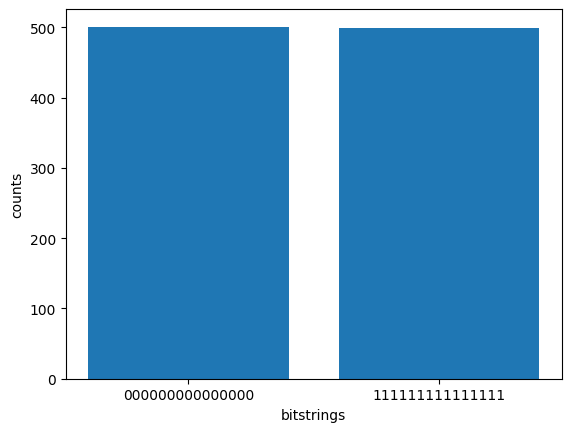

In [11]:
# define a 15-qubit GHZ circuit
n_qubits = 15
ghz = ghz_circuit(n_qubits)

# run GHZ circuit on SV1
result = device.run(ghz, shots=1000, isBinaryDecisionTree=True).result()
counts = result.measurement_counts
print(counts)

# plot using Counter
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')

# print counts of all-zero-string
print('Counts for all-zero bitstring:', counts['0'*n_qubits])
# print counts of all-one-string
print('Counts for all-one bitstring:', counts['1'*n_qubits])

The following example demonstrates that Qrack can easily simulate GHZ circuits with up to (and past) 50 qubits.

In [12]:
# define a larger GHZ circuit
n_qubits = 50
ghz = ghz_circuit(n_qubits)

# either one of these should work for 50 qubit GHZ states, with Qrack, but stabilizer will complete nearly instantaneously
result = device.run(ghz, shots=1000, isStabilizerHybrid=True, isSchmidtDecompose=False, isTensorNetwork=False).result()
# result = device.run(ghz, shots=1000, isBinaryDecisionTree=True).result()

counts = result.measurement_counts
print(counts)

# print counts of all-zero-string
print('Counts for all-zero bitstring:', counts['0'*n_qubits])
# print counts of all-one-string
print('Counts for all-one bitstring:', counts['1'*n_qubits])

Counter({'11111111111111111111111111111111111111111111111111': 507, '00000000000000000000000000000000000000000000000000': 493})
Counts for all-zero bitstring: 493
Counts for all-one bitstring: 507


In [13]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Quantum Task Summary
{}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.00 USD
